# Importing and loading data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

df = pd.read_csv('20200124_ews_observations.csv', low_memory=False)
df = df.dropna()
df['ObservationDate'] = pd.to_datetime(df['ObservationDate'])

**Function that deletes the unnecessary columns so that only columns with numbers are kept and the datetime**

In [2]:
def remove_scores(df):
    df = df.drop(['SBP_Score', 'SpO2_Score', 'HR_Score', 'TEMP_Score', 'RR_Score', 'EwsProcedure', 'Add_O2', 'LOC'], axis=1)
    return df

**Function that returns a dataframe of the patient and some info about the measurements**

In [3]:
def analyse_patient (df, id_nr, plot=False):
    # only select rows from the patient
    patient = df.loc[df['PatientId'] == id_nr]
    patient = patient.sort_values(by='ObservationDate', ascending=True)
    # datetime as index
    patient = patient.set_index('ObservationDate')
    # drop NAN values and check how many samples are useful
    patient = patient.dropna()
    n_measurements = patient.shape[0]
    print(f"Number of measurements: {n_measurements}")
    
    patient = patient.drop(['EwsProcedure'], axis=1)
    
    # print the info
    if n_measurements > 1:
        # print average minimum and maximum time between measurements
        delta_t = patient.index.to_series().diff().dt.seconds.div(3600, fill_value=0)
        delta_t_avg = delta_t.mean()
        delta_t_max = delta_t.max()
        delta_t_min = delta_t.nsmallest(2).iloc[1]
        print(f"Average time (hours) between measurements of patient {id_nr}: {delta_t_avg}")
        print(f"Max diff time between measurements: {delta_t_max}")
        print(f"Min diff time between measurements: {delta_t_min}")
        
        # print start and end date of hospitalisation
        start_date = patient.index.values[0]
        end_date = patient.index.values[-1]
        print(f"Start_date: {start_date}")
        print(f"End_date: {end_date}")
        
        # check how many data we have on the patient
        delta_t = end_date - start_date
        delta_days = delta_t.astype('timedelta64[D]').astype('str')
        # delta_days prints "xx days"
        # next line cuts " days" out of the string delta_days
        delta_days = delta_days[:len(delta_days) - 5]
        print(f"Hospitalisation duration: {delta_days}")
        
    else:
        print("Only 1 measurement")
    
    
    if int(delta_days) >= 2 and n_measurements >= 15:
        to_predict = True
        print("This patient has enough data to apply an accurate model")
    else:
        to_predict = False
        print("Not enough data yet to predict EWS")
    
    # plot timeseries
    if plot:
        fig, ax = plt.subplots(figsize=(15,15))
        sns.lineplot(data=patient, x="ObservationDate", y='EWS_Total', linestyle='-', color='grey', ax=ax)
        sns.scatterplot(data=patient, x="ObservationDate", y='EWS_Total', marker='o', linestyle='-', hue="Add_O2_Score", palette="tab10", ax=ax)
    
    return patient, n_measurements, to_predict

In [4]:
patientx = analyse_patient(df, 1743)
patientx[0].head()

Number of measurements: 616
Average time (hours) between measurements of patient 1743: 7.080062680375186
Max diff time between measurements: 23.8975
Min diff time between measurements: 0.0022222222222222222
Start_date: 2019-06-15T13:32:39.000000000
End_date: 2020-01-02T06:51:46.000000000
Hospitalisation duration: 200
This patient has enough data to apply an accurate model


,PatientId,EWS_Total,SBP,SBP_Score,LOC,LOC_Score,SpO2,SpO2_Score,Add_O2,Add_O2_Score,HR,HR_Score,RR,RR_Score,TEMP,TEMP_Score
ObservationDate,,,,,,,,,,,,,,,,
2019-06-15 13:32:39,1743,4,122.0,0.0,ALERT,0,91.0,0.0,True,2.0,112,2,18,0,36.6,0
2019-06-15 20:22:36,1743,5,109.0,1.0,ALERT,0,93.0,1.0,True,2.0,104,1,16,0,37.0,0
2019-06-16 14:23:34,1743,3,117.0,0.0,ALERT,0,89.0,0.0,True,2.0,103,1,19,0,36.5,0
2019-06-16 19:49:24,1743,3,123.0,0.0,ALERT,0,90.0,0.0,True,2.0,107,1,19,0,36.6,0
2019-06-17 04:39:15,1743,4,102.0,1.0,ALERT,0,92.0,0.0,True,2.0,97,1,18,0,36.7,0


**Function that returns a dictionary of the d values of the metrics**

In [5]:
def n_diffs(df_patient):
    from pmdarima.arima.utils import ndiffs
    n_diffs_dict  = {}
    metrics = ['SBP', 'SpO2', 'HR', 'RR', 'TEMP']
    for column in metrics:
        y = df_patient[column]
        n_diffs = ndiffs(y, test='adf')
        n_diffs_dict[column] = n_diffs
    return n_diffs_dict

**Function that returns a dictionary of the parameters of the models for each of the metrics**

In [6]:
def get_best_pdq(df_patient):
    from pmdarima.arima import auto_arima
    metric_pdq_dict = {}
    dict_ndiffs = n_diffs(df_patient)
    for metric in dict_ndiffs:
        ndiffs = dict_ndiffs[metric]
        best_pdq = auto_arima(df_patient[metric], d=ndiffs, trace=False)
        metric_pdq_dict[metric] = best_pdq.order
    return metric_pdq_dict

In [7]:
# from sklearn.metrics import mean_squared_error
# def pdq(df_patient):
#     from pmdarima.arima import auto_arima
#     metric_pdq_dict = {}
#     dict_ndiffs = n_diffs(df_patient)
#     for metric in dict_ndiffs:
#         X = df_patient[metric]
#         print(X)
#         size = int(len(X) * 0.66)
#         train, test = X[0:size], X[size:len(X)]
#         ndiffs = dict_ndiffs[metric]
#         model = auto_arima(train, d=ndiffs, trace=False)
#         preds, conf_int = model.predict(n_periods=test.shape[0], return_conf_int=True)
#         print(f"Test RMSE {metric}: {np.sqrt(mean_squared_error(test, preds))}" )
        
#         # Plot the points and the forecasts
#         x_axis = np.arange(train.shape[0] + preds.shape[0])
#         x_years = x_axis + 1821  # Year starts at 1821

#         plt.plot(x_years[x_axis[:train.shape[0]]], train, alpha=0.75)
#         plt.plot(x_years[x_axis[train.shape[0]:]], preds, alpha=0.75)  # Forecasts
#         plt.scatter(x_years[x_axis[train.shape[0]:]], test,
#             alpha=0.4, marker='x')  # Test data
#         plt.fill_between(x_years[x_axis[-preds.shape[0]:]],
#                  conf_int[:, 0], conf_int[:, 1],
#                  alpha=0.1, color='b')
#         plt.title("Lynx forecasts")
#         plt.xlabel("Year")
#     return metric_pdq_dict
# pdq(patientx)

**Function that models and fits an ARIMA model for each of the metrics and also plots things**

In [8]:
def model_and_predict(df_patient):
    from pmdarima.arima import ARIMA
    from sklearn.model_selection import TimeSeriesSplit
    from math import sqrt, floor
    from sklearn.metrics import mean_squared_error
    from statistics import mean
    
    metrics = ['SBP', 'SpO2', 'HR', 'RR', 'TEMP']
    pdq_dict = get_best_pdq(df_patient)
    print(pdq_dict)
    for metric in metrics:
        print(f"-----------------------------{metric}--------------------------------")
        pdq_order = int(max(pdq_dict[metric])+1)
        X = df_patient[metric].values
        error_values = []
        for i in range(pdq_order, len(X)):
            X_train = X[i-pdq_order:i]
            X_test = X[i]
            model = ARIMA(order=pdq_dict[metric])
            X_predict = model.fit_predict(X_train, n_periods=1)
            error = abs(X_predict - X_test)
            error_values.append(error)
        
        squared_errors = [error ** 2 for error in error_values]
        rmse = sqrt((sum(squared_errors))/len(squared_errors))
        print(f"RMSE for {metric}: {rmse}")
        
        
            
            

#         plt.plot(X_train, y_train, color='grey')
#         plt.plot(X_test, predictions_test, color='red')
#         plt.plot(X_test, y_test, color='green')
        
#         plt.show()

In [9]:
def model_and_predict2(df_patient, predict_n):
    from pmdarima.arima import ARIMA
    from sklearn.model_selection import TimeSeriesSplit
    from math import sqrt
    from sklearn.metrics import mean_squared_error
    
    metrics = ['SBP', 'SpO2', 'HR', 'RR', 'TEMP']
    pdq_dict = get_best_pdq(df_patient)
    print(pdq_dict)
    dict_predictions = {}
    
    for metric in metrics:
        X = df_patient[metric].values
        size = int(len(X) * 0.7)
        #size = int(max(pdq_dict[metric])+1)
        train, test = X[0:size], X[size:len(X)]
        history = [x for x in train]
        predictions = []
        print(f"-----------------------------{metric}--------------------------------")
        
        # rolling forecast to get rmse
        for t in range(len(test)): 
            model = ARIMA(order=(pdq_dict[metric]))
            output = model.fit_predict(history, n_periods=2)
            yhat = output[0]
            predictions.append(yhat)
            obs = test[t]
            history.append(obs)
            #print('predicted=%f, expected=%f' % (yhat, obs))
        # evaluate forecasts
        rmse = sqrt(mean_squared_error(test, predictions))
        print(f'Test RMSE {metric}: {rmse}')
        
        # predict next n samples
        predict_metric = model.predict(n_periods=predict_n)
        predict_metric_x = [i-1 + len(predictions)  for i in range(predict_n)]
        predict_df = pd.DataFrame(data=predict_metric, index=predict_metric_x)
        
        dict_predictions[metric] = predict_df
        
        print(predict_metric)
        # plot forecasts against actual outcomes
        plt.title(metric)
        plt.plot(test, color='grey')
        plt.plot(predictions, color='red')
        plt.plot(predict_df, color='green')
        plt.savefig(fname=metric+'1092')
        plt.show()
        
    return dict_predictions
        

{'SBP': (5, 0, 5), 'SpO2': (1, 0, 5), 'HR': (3, 0, 0), 'RR': (3, 0, 3), 'TEMP': (3, 0, 0)}
-----------------------------SBP--------------------------------
Test RMSE SBP: 8.247746974969713
[113.21818835 114.66940756 111.56051232 112.36001443 113.29911579]


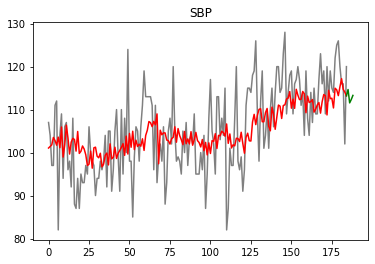

-----------------------------SpO2--------------------------------
Test RMSE SpO2: 2.6480689888195927
[93.68171413 93.21778754 93.13129303 92.77491726 92.77665146]


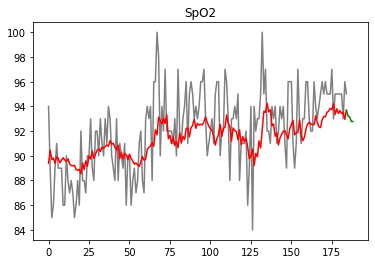

-----------------------------HR--------------------------------
Test RMSE HR: 7.613313912757962
[ 99.66685844 103.69392828 101.47791306 100.56459387 102.32235873]


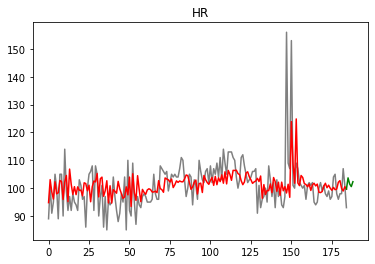

-----------------------------RR--------------------------------
Test RMSE RR: 2.6575523336283364
[18.14264096 18.41122275 18.65996667 18.36798748 18.00922972]


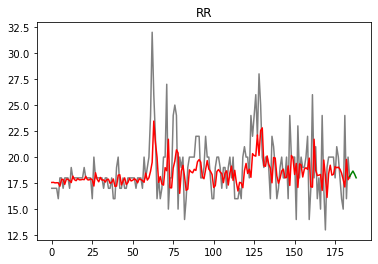

-----------------------------TEMP--------------------------------
Test RMSE TEMP: 0.4251056841689376
[36.87003532 36.95073724 36.84486497 36.77743359 36.78609414]


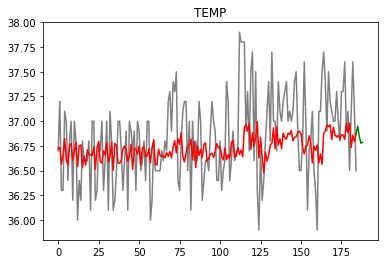

{'SBP':               0
184  113.218188
185  114.669408
186  111.560512
187  112.360014
188  113.299116, 'SpO2':              0
184  93.681714
185  93.217788
186  93.131293
187  92.774917
188  92.776651, 'HR':               0
184   99.666858
185  103.693928
186  101.477913
187  100.564594
188  102.322359, 'RR':              0
184  18.142641
185  18.411223
186  18.659967
187  18.367987
188  18.009230, 'TEMP':              0
184  36.870035
185  36.950737
186  36.844865
187  36.777434
188  36.786094}


In [10]:
import warnings
warnings.filterwarnings('ignore')

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

predictions_patientx = model_and_predict2(patientx[0], 5)
print(predictions_patientx)

In [11]:
SBP = predictions_patientx['SBP']
SBP = SBP[0].iloc[4]
SBP

113.29911579351219

In [12]:
def calculate_ews(df_patient, predictions_data):
    list_ews = []
    n_predictions = len(predictions_data['SBP'][0])
    for i in range(n_predictions):
        SBP = predictions_data['SBP']
        SBP = SBP[0].iloc[i]

        SpO2 = predictions_data['SpO2']
        SpO2 = SpO2[0].iloc[i]
        
        HR = predictions_data['HR']
        HR = HR[0].iloc[i]

        RR = predictions_data['RR']
        RR = RR[0].iloc[i]

        TEMP = predictions_data['TEMP']
        TEMP = TEMP[0].iloc[i]

        LOC_Score = df_patient['LOC_Score'].iloc[-1]

        Add_O2_Score = df_patient['Add_O2_Score'].iloc[-1]

        ews = calculate_news2_scale1(RR, SpO2, Add_O2_Score, SBP, HR, LOC_Score, TEMP, check=False)
        print(f"{i}: {ews}")
        list_ews.append(ews)

    return list_ews
    

In [13]:
ews_predictions = calculate_ews(patientx[0], predictions_patientx)

NameError: name 'calculate_news2_scale1' is not defined

In [ ]:
patientx[0]['EWS_Total']

**Functions that converts scores to EWS Total score**  
Two scales for SpO2

In [ ]:
def calculate_news2_scale1 (rr, spo2, air_score, sbp, hr, loc_score, temp, check=False):
    score = 0
    # RR SCORE - normal values: 12-20
    if rr <= 8 or rr >= 25:
        rr_score = 3
    elif 21 <= rr <= 24:
        rr_score = 2
    elif 9 <= rr <= 11:
        rr_score = 1
    else:
        rr_score = 0
    
    # SPO2 SCORE - normal values: >= 96
    if spo2 <= 91:
        spo2_score = 3
    elif 92 <= spo2 <= 93:
        spo2_score = 2
    elif 94 <= spo2 <= 95:
        spo2_score = 1
    else:
        spo2_score = 0
    
    # OXYGEN METHOD SCORE 
    # 0 -> Room Air 
    # 3 -> Oxygen Mask
    try:
        assert air_score == 0 or air_score == 2, "Air_score is not 0 or 2"
    except AssertionError:
        raise
    
    # SBP SCORE - normal values: 111-219
    if sbp <= 90 or sbp >= 220:
        sbp_score = 3
    elif 91 <= sbp <= 100:
        sbp_score = 2
    elif 101 <= sbp <= 110:
        sbp_score = 1
    else:
        sbp_score = 0
    
    # HR SCORE - normal values: 51-90
    if hr <= 40 or hr >= 131:
        hr_score = 3
    elif 111 <= hr <= 130:
        hr_score = 2
    elif 91 <= hr <= 110 or 41 <= hr <= 50:
        hr_score = 1
    else:
        hr_score = 0
    
    # CONSCIOUSNESS METHOD SCORE 
    # 0 -> Alert 
    # 3 -> CVPU (Confusion, Voice, Pain, Unresponsive)
    try:
        assert loc_score == 0 or loc_score == 3, "loc_score is not 0 or 3"
    except AssertionError:
        raise
    
    # TEMP SCORE - normal values: 51-90
    if temp <= 35.0:
        temp_score = 3
    elif temp > 39.1:
        temp_score = 2
    elif 35.1 <= temp <= 36.0 or 38.1 <= temp <= 39.0:
        temp_score = 1
    else:
        temp_score = 0
    
    if check:
        print(f'rr_score: {rr_score}')
        print(f'spo2_score: {spo2_score}')
        print(f'air_score: {air_score}')
        print(f'sbp_score: {sbp_score}')
        print(f'hr_score: {hr_score}')
        print(f'loc_score: {loc_score}')
        print(f'temp_score: {temp_score}')
    
    ews_total = rr_score + spo2_score + air_score + sbp_score + hr_score + loc_score + temp_score
    
    return ews_total

In [ ]:
def calculate_news2_scale2 (rr, spo2, air_score, sbp, hr, loc_score, temp, check=False):
    score = 0
    # RR SCORE - normal values: 12-20
    if rr <= 8 or rr >= 25:
        rr_score = 3
    elif 21 <= rr <= 24:
        rr_score = 2
    elif 9 <= rr <= 11:
        rr_score = 1
    else:
        rr_score = 0
    
    # SPO2 SCORE - normal values: >= 96
    if spo2 <= 83 or spo2 >= 97:
        spo2_score = 3
    elif 84 <= spo2 <= 85 or 95 <= spo2 <= 96:
        spo2_score = 2
    elif 86 <= spo2 <= 87 or 93 <= spo2 <= 94:
        spo2_score = 1
    else:
        spo2_score = 0
    
    # OXYGEN METHOD SCORE 
    # 0 -> Room Air 
    # 3 -> Oxygen Mask
    try:
        assert air_score == 0 or air_score == 2, "Air_score is not 0 or 2"
    except AssertionError:
        raise
    
    # SBP SCORE - normal values: 111-219
    if sbp <= 90 or sbp >= 220:
        sbp_score = 3
    elif 91 <= sbp <= 100:
        sbp_score = 2
    elif 101 <= sbp <= 110:
        sbp_score = 1
    else:
        sbp_score = 0
    
    # HR SCORE - normal values: 51-90
    if hr <= 40 or hr >= 131:
        hr_score = 3
    elif 111 <= hr <= 130:
        hr_score = 2
    elif 91 <= hr <= 110 or 41 <= hr <= 50:
        hr_score = 1
    else:
        hr_score = 0
    
    # CONSCIOUSNESS METHOD SCORE 
    # 0 -> Alert 
    # 3 -> CVPU (Confusion, Voice, Pain, Unresponsive)
    try:
        assert loc_score == 0 or loc_score == 3, "loc_score is not 0 or 3"
    except AssertionError:
        raise
    
    # TEMP SCORE - normal values: 51-90
    if temp <= 35.0:
        temp_score = 3
    elif temp > 39.1:
        temp_score = 2
    elif 35.1 <= temp <= 36.0 or 38.1 <= temp <= 39.0:
        temp_score = 1
    else:
        temp_score = 0
    
    if check:
        print(f'rr_score: {rr_score}')
        print(f'spo2_score: {spo2_score}')
        print(f'air_score: {air_score}')
        print(f'sbp_score: {sbp_score}')
        print(f'hr_score: {hr_score}')
        print(f'loc_score: {loc_score}')
        print(f'temp_score: {temp_score}')
    
    ews_total = rr_score + spo2_score + air_score + sbp_score + hr_score + loc_score + temp_score
    
    return ews_total

In [ ]:
def check_hit_acc (df, samples, to_print=False):
# if there is a hit with either of the scales it will append true to this list
    check_row = []
    test_df = df.sample(n=samples)
    # check every row and apply calculate_news2_scale1
    for index, row in test_df.iterrows():
        ews_row_calc = calculate_news2_scale1(rr=row.RR, spo2=row.SpO2, air_score=row.Add_O2_Score, sbp=row.SBP, 
                                       hr=row.HR, loc_score=row.LOC_Score, temp=row.TEMP, check=to_print)
        if int(ews_row_calc) == int(row.EWS_Total):
            check_row.append(True)
            if to_print == True:
                print("-----")
        # if this isn't a hit, apply calculate_news2_scale2 
        else:
            ews_row_calc_2 = calculate_news2_scale2(rr=row.RR, spo2=row.SpO2, air_score=row.Add_O2_Score, sbp=row.SBP, 
                                       hr=row.HR, loc_score=row.LOC_Score, temp=row.TEMP, check=to_print)
            if ews_row_calc_2 == int(row.EWS_Total):
                check_row.append(True)
                if to_print == True:
                    print("-----")
            # if both of the calculate methods fail, false will be appended to the list
            else:
                check_row.append(False)
                if to_print == True:
                    print(f"{row.name}: false")
                    print(f"calculated: {ews_row_calc} != given: {row.EWS_Total}")
                    print("-----")
    # print the accuracy of this function
    hit_perc = (check_row.count(True)/len(check_row))*100
    print(f"Accuracy of function: {hit_perc}")

In [ ]:
hit_acc_50 = check_hit_acc(df, samples=5000)